In [1]:
# https://theailearner.com/2019/05/29/creating-a-crnn-model-to-recognize-text-in-an-image-part-2
# https://keras.io/examples/vision/handwriting_recognition
# https://github.com/pbcquoc/crnn
import sys
import tensorflow as tf
sys.path.append('..')
tf.get_logger().setLevel('ERROR')
APPROACH_NAME = 'FeaturesAverage'

# Check GPU working

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


# Data input pipeline

In [3]:
DATASET_DIR = r'../../Dataset/trdg'
LABELS_PATH = r'../../Dataset/trdg/labels.txt'
FONT_PATH = r'../../Dataset/NomNaTong-Regular.ttf'

## Load and remove records with rare characters 

In [4]:
from loader import DataImporter
dataset = DataImporter(DATASET_DIR, LABELS_PATH, min_length=6).remove_rare_chars(2)
print(dataset)

Number of images found: 4069
Number of labels found: 4069
Number of unique characters: 2033
Characters present: {'浪': 308, '㐌': 304, '\U000f070b': 236, '朱': 234, '𠊛': 232, '\U000f047c': 215, '尼': 215, '娘': 206, '𢚸': 202, '固': 201, '吏': 201, '𦋦': 191, '拱': 180, '之': 163, '埃': 159, '群': 153, '𠳒': 150, '情': 147, '芇': 147, '買': 147, '別': 134, '欺': 125, '麻': 125, '𠓨': 124, '𠬠': 124, '仙': 120, '𡗶': 116, '爫': 116, '𧗱': 114, '花': 106, '𦖑': 105, '浽': 104, '𠄩': 102, '呐': 102, '命': 102, '渚': 101, '塘': 99, '饒': 98, '𠫾': 97, '些': 97, '渃': 97, '如': 96, '時': 95, '強': 94, '分': 93, '低': 92, '𡢐': 91, '傷': 91, '払': 91, '牢': 88, '𫽄': 85, '仍': 83, '咍': 82, '冲': 81, '昆': 81, '鐄': 81, '於': 80, '身': 79, '庒': 79, '生': 77, '𧡊': 77, '月': 76, '𢬣': 75, '𣈜': 75, '沛': 74, '調': 74, '茹': 74, '﨤': 72, '皮': 72, '油': 71, '\U000f061a': 71, '細': 71, '催': 70, '公': 70, '典': 70, '緣': 69, '畧': 68, '戈': 68, '碎': 67, '排': 67, '爲': 66, '𠁀': 64, '娥': 64, '\U000f02c7': 62, '包': 61, '共': 61, '貝': 59, '𢧚': 58, '㗂': 57, '恩': 57, '賒': 

## Data constants and input pipeline

In [5]:
HEIGHT = 148
WIDTH = 32
PADDING_CHAR = '[PAD]' 

In [6]:
from loader import DataHandler
data_handler = DataHandler(dataset, img_size=(HEIGHT, WIDTH), padding_char=PADDING_CHAR)
MAX_LENGTH = data_handler.max_length
PADDING_TOKEN = data_handler.padding_token
VOCAB_SIZE = data_handler.char2num.vocab_size()
BATCH_SIZE = 16

## Visualize the data

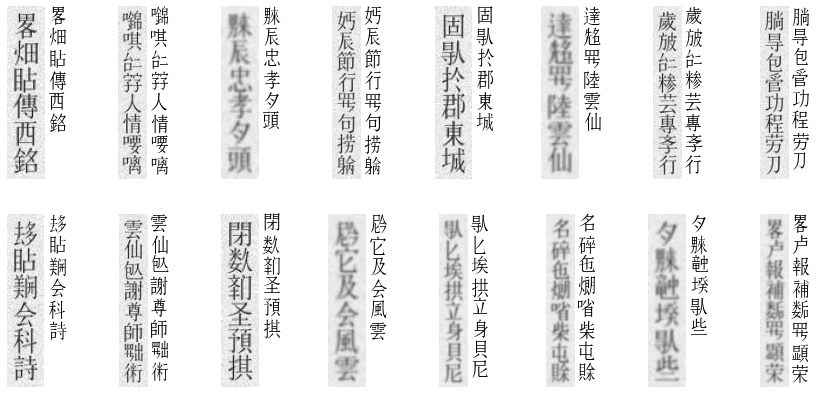

In [7]:
from visualizer import visualize_images_labels
img_paths, labels = dataset.img_paths, dataset.labels 
visualize_images_labels(img_paths, labels, font_path=FONT_PATH, text_x=WIDTH + 3)

# Define the model

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Bidirectional, GRU,
    Lambda, RepeatVector, Permute, multiply
)
from cnn import custom_cnn, get_imagenet_model, reshape_for_rnn

In [9]:
# https://pbcquoc.github.io/vietnamese-ocr (Vietnamese blog)
def visual_attention(feature_maps):
    _, timestep, input_dim = feature_maps.shape
    a = Permute((2, 1), name='dim_switching')(feature_maps)
    a = Dense(timestep, activation='softmax', name='attention_weights')(a)
    
    # Calculate the average of all timesteps and multiply by 100 to convert
    # the fraction obtained from the softmax calculation into a percentage
    a = Lambda(
        lambda x: tf.keras.backend.mean(x, axis=1) * 100, 
        name = 'weighted_average'
    )(a)
    
    a = RepeatVector(input_dim, name='redistribute')(a)
    a = Permute((2, 1), name='attention_vector')(a) 
    return multiply([feature_maps, a], name='context_vector') 

In [10]:
def build_crnn(imagenet_model=None, imagenet_output_layer=None, name='CRNN'):
    label_input = Input(shape=(None,), dtype='int64', name='label')
    label_length = Input(shape=[1], dtype='int64', name='label_length')
    
    # CNN layers
    if imagenet_model: # Use Imagenet model as CNN layers
        image_input = imagenet_model.input
        imagenet_model.layers[0]._name = 'image'
        x = imagenet_model.get_layer(imagenet_output_layer).output
    else: 
        image_input = Input(shape=(HEIGHT, WIDTH, 1), dtype='float32', name='image')
        conv_blocks_config = {
            'block1': {'num_conv': 1, 'filters':  64, 'pool_size': (2, 2)}, 
            'block2': {'num_conv': 1, 'filters': 128, 'pool_size': (2, 2)}, 
            'block3': {'num_conv': 2, 'filters': 256, 'pool_size': (2, 2)}, 
            'block4': {'num_conv': 2, 'filters': 512, 'pool_size': (1, 2)}, 
        }
        x = custom_cnn(conv_blocks_config, image_input)
        
    # Reshape accordingly before passing output to RNN and apply attention mechanism
    x = reshape_for_rnn(x, dim_to_keep=1)
    x = visual_attention(x)
    
    # RNN layers
    bigru_layers = [512, 512]
    for idx in range(len(bigru_layers)):
        x = Bidirectional(GRU(
            units = bigru_layers[idx], 
            return_sequences = True, 
            dropout = 0.4,
        ), name = f'bigru{idx + 1}')(x)

    # Output layer
    y_pred = Dense(
        units = VOCAB_SIZE + 1, # + 1 blank character for CTC loss
        activation = 'softmax', 
        name = 'rnn_output'
    )(x)
    model = Model(inputs=image_input, outputs=y_pred, name=name)
    return model

In [11]:
imagenet_model, imagenet_output_layer = None, None
# # Pick a model from https://keras.io/api/applications
# imagenet_model = get_imagenet_model('VGG16', (HEIGHT, WIDTH, 1))
# imagenet_output_layer = 'block4_pool'
# imagenet_model.summary(line_length=100)

In [12]:
model = build_crnn(imagenet_model, imagenet_output_layer)
model.summary(line_length=100)

Model: "CRNN"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 image (InputLayer)              [(None, 148, 32, 1)]  0           []                               
                                                                                                    
 block1_conv1 (Conv2D)           (None, 148, 32, 64)   640         ['image[0][0]']                  
                                                                                                    
 block1_bn1 (BatchNormalization)  (None, 148, 32, 64)  256         ['block1_conv1[0][0]']           
                                                                                                    
 block1_activation1 (LeakyReLU)  (None, 148, 32, 64)   0           ['block1_bn1[0][0]']             
                                                                             

# Training

In [13]:
from tensorflow.keras.optimizers import Adam
from kfold import kfold_decorator
from metrics import MeanEditDistance
from losses import CTCLoss

In [14]:
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from callbacks import EarlyStoppingWithStuck
LEARNING_RATE = 2e-4
EPOCHS = 100

## Callbacks

In [15]:
stuck_str = 'val_loss - loss >= 10 or (epoch > 5 and val_loss > 30)'
early_stopping_callback = EarlyStoppingWithStuck(patience=5, stuck_str=stuck_str)

def scheduler(epoch, lr):
    if epoch < 1 or (epoch % 5) > 0: return lr # Keeps lr for each 5 epochs
    return lr * tf.math.exp(-0.2) # Decreases it exponentially after that
schedule_lr_callback = LearningRateScheduler(scheduler, verbose=1)

# Reduce the learning rate once learning stagnates
reduce_lr_callback = ReduceLROnPlateau(
    monitor = 'val_loss', 
    patience = 2, # Reduce if no improvement after 2 epochs
    min_lr = 1e-6, # Lower bound on the learning rate 
    factor = 0.5, # => new_lr = lr * factor
    verbose = 1
)

## Cross validation with K-Fold

In [16]:
@kfold_decorator(n_splits=10, random_state=2022)
def train(model, img_paths, labels, train_idxs=None, valid_idxs=None):
    train_tf_dataset = data_handler.prepare_tf_dataset(train_idxs, BATCH_SIZE)
    valid_tf_dataset = data_handler.prepare_tf_dataset(valid_idxs, BATCH_SIZE)
    
    model.compile(
        optimizer = Adam(learning_rate=LEARNING_RATE), 
        loss = CTCLoss(PADDING_TOKEN), 
        metrics = [MeanEditDistance(PADDING_TOKEN, MAX_LENGTH, use_ctc_decode=True)]
    )
    history = model.fit(
        train_tf_dataset,
        validation_data = valid_tf_dataset,
        epochs = EPOCHS,
        callbacks = [
            early_stopping_callback,
            reduce_lr_callback, 
#             schedule_lr_callback, 
        ],
        verbose = 1
    ).history
    return valid_tf_dataset, early_stopping_callback.best_epoch, history, model

In [17]:
%%time
valid_datasets, best_epochs, histories, models = train(model, img_paths, labels)

============== Fold 01 training ==============
Epoch 1/100
229/229 [==============================] - 17s 44ms/step - loss: 51.3534 - edist: 7.1192 - val_loss: 53.2373 - val_edist: 7.0078 - lr: 2.0000e-04
Epoch 2/100
229/229 [==============================] - 8s 35ms/step - loss: 46.1307 - edist: 7.0107 - val_loss: 48.2231 - val_edist: 6.8472 - lr: 2.0000e-04
Epoch 3/100
229/229 [==============================] - 8s 34ms/step - loss: 38.9436 - edist: 5.7413 - val_loss: 36.3162 - val_edist: 5.3308 - lr: 2.0000e-04
Epoch 4/100
229/229 [==============================] - 8s 35ms/step - loss: 25.6377 - edist: 3.5875 - val_loss: 22.5898 - val_edist: 4.0288 - lr: 2.0000e-04
Epoch 5/100
229/229 [==============================] - 8s 33ms/step - loss: 16.0989 - edist: 2.0936 - val_loss: 15.6939 - val_edist: 2.7906 - lr: 2.0000e-04
Epoch 6/100
229/229 [==============================] - 8s 34ms/step - loss: 10.3702 - edist: 1.3037 - val_loss: 12.1304 - val_edist: 2.0740 - lr: 2.0000e-04
Epoch 7/10

229/229 [==============================] - ETA: 0s - loss: 0.0154 - edist: 0.0000e+00
Epoch 49: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
229/229 [==============================] - 8s 34ms/step - loss: 0.0154 - edist: 0.0000e+00 - val_loss: 2.1281 - val_edist: 0.4820 - lr: 2.5000e-05
Epoch 50/100
229/229 [==============================] - 8s 36ms/step - loss: 0.0149 - edist: 0.0000e+00 - val_loss: 2.1333 - val_edist: 0.4150 - lr: 1.2500e-05
Epoch 51/100
229/229 [==============================] - ETA: 0s - loss: 0.0146 - edist: 0.0000e+00
Epoch 51: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
229/229 [==============================] - 8s 36ms/step - loss: 0.0146 - edist: 0.0000e+00 - val_loss: 2.1181 - val_edist: 0.4824 - lr: 1.2500e-05
Epoch 52/100
229/229 [==============================] - 8s 36ms/step - loss: 0.0145 - edist: 0.0000e+00 - val_loss: 2.1344 - val_edist: 0.4267 - lr: 6.2500e-06
Early stopping and restored the model weights fr

229/229 [==============================] - 8s 35ms/step - loss: 0.0151 - edist: 0.0000e+00 - val_loss: 1.5978 - val_edist: 0.2777 - lr: 1.2500e-05
Epoch 42/100
229/229 [==============================] - 8s 35ms/step - loss: 0.0148 - edist: 0.0000e+00 - val_loss: 1.6012 - val_edist: 0.2782 - lr: 1.2500e-05
Epoch 43/100
229/229 [==============================] - 8s 35ms/step - loss: 0.0146 - edist: 0.0000e+00 - val_loss: 1.5938 - val_edist: 0.2792 - lr: 1.2500e-05
Epoch 44/100
229/229 [==============================] - 8s 34ms/step - loss: 0.0143 - edist: 0.0000e+00 - val_loss: 1.6009 - val_edist: 0.2802 - lr: 1.2500e-05
Epoch 45/100
229/229 [==============================] - ETA: 0s - loss: 0.0140 - edist: 0.0000e+00
Epoch 45: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
229/229 [==============================] - 8s 35ms/step - loss: 0.0140 - edist: 0.0000e+00 - val_loss: 1.5958 - val_edist: 0.2807 - lr: 1.2500e-05
Epoch 46/100
229/229 [=============================

============== Fold 04 training ==============
Epoch 1/100
229/229 [==============================] - 13s 38ms/step - loss: 51.4330 - edist: 7.1249 - val_loss: 53.7194 - val_edist: 6.8741 - lr: 2.0000e-04
Epoch 2/100
229/229 [==============================] - 7s 32ms/step - loss: 46.6110 - edist: 7.1068 - val_loss: 50.8740 - val_edist: 6.8740 - lr: 2.0000e-04
Epoch 3/100
229/229 [==============================] - 7s 33ms/step - loss: 39.6943 - edist: 5.5152 - val_loss: 38.2132 - val_edist: 5.7311 - lr: 2.0000e-04
Epoch 4/100
229/229 [==============================] - 7s 33ms/step - loss: 24.1819 - edist: 3.2409 - val_loss: 20.0308 - val_edist: 3.2523 - lr: 2.0000e-04
Epoch 5/100
229/229 [==============================] - 8s 33ms/step - loss: 14.1776 - edist: 1.6137 - val_loss: 13.3773 - val_edist: 2.1934 - lr: 2.0000e-04
Epoch 6/100
229/229 [==============================] - 8s 33ms/step - loss: 8.4938 - edist: 0.8041 - val_loss: 9.8059 - val_edist: 1.6250 - lr: 2.0000e-04
Epoch 7/100


229/229 [==============================] - 8s 34ms/step - loss: 0.0151 - edist: 0.0000e+00 - val_loss: 1.6405 - val_edist: 0.6210 - lr: 6.2500e-06
Epoch 48/100
229/229 [==============================] - 8s 35ms/step - loss: 0.0149 - edist: 0.0000e+00 - val_loss: 1.6535 - val_edist: 0.6230 - lr: 6.2500e-06
Epoch 49/100
229/229 [==============================] - ETA: 0s - loss: 0.0147 - edist: 0.0000e+00
Epoch 49: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
229/229 [==============================] - 8s 33ms/step - loss: 0.0147 - edist: 0.0000e+00 - val_loss: 1.6546 - val_edist: 0.6230 - lr: 6.2500e-06
Epoch 50/100
229/229 [==============================] - 8s 34ms/step - loss: 0.0144 - edist: 0.0000e+00 - val_loss: 1.6527 - val_edist: 0.6220 - lr: 3.1250e-06
Epoch 51/100
229/229 [==============================] - ETA: 0s - loss: 0.0142 - edist: 0.0000e+00
Epoch 51: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
229/229 [===========================

229/229 [==============================] - ETA: 0s - loss: 0.0205 - edist: 0.0000e+00
Epoch 40: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
229/229 [==============================] - 8s 33ms/step - loss: 0.0205 - edist: 0.0000e+00 - val_loss: 1.7812 - val_edist: 0.2371 - lr: 2.5000e-05
Epoch 41/100
229/229 [==============================] - 8s 34ms/step - loss: 0.0198 - edist: 0.0000e+00 - val_loss: 1.7635 - val_edist: 0.2389 - lr: 1.2500e-05
Epoch 42/100
229/229 [==============================] - 8s 33ms/step - loss: 0.0193 - edist: 0.0000e+00 - val_loss: 1.7690 - val_edist: 0.2430 - lr: 1.2500e-05
Epoch 43/100
229/229 [==============================] - ETA: 0s - loss: 0.0189 - edist: 0.0000e+00
Epoch 43: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
229/229 [==============================] - 8s 33ms/step - loss: 0.0189 - edist: 0.0000e+00 - val_loss: 1.7654 - val_edist: 0.2430 - lr: 1.2500e-05
Epoch 44/100
229/229 [==========================

229/229 [==============================] - 8s 34ms/step - loss: 0.0284 - edist: 0.0000e+00 - val_loss: 2.0118 - val_edist: 0.3250 - lr: 2.5000e-05
Epoch 34/100
229/229 [==============================] - 8s 34ms/step - loss: 0.0277 - edist: 0.0000e+00 - val_loss: 1.9947 - val_edist: 0.3214 - lr: 2.5000e-05
Epoch 35/100
229/229 [==============================] - 8s 36ms/step - loss: 0.0270 - edist: 0.0000e+00 - val_loss: 1.9933 - val_edist: 0.3400 - lr: 2.5000e-05
Epoch 36/100
229/229 [==============================] - 8s 34ms/step - loss: 0.0258 - edist: 0.0000e+00 - val_loss: 2.0170 - val_edist: 0.3238 - lr: 2.5000e-05
Epoch 37/100
229/229 [==============================] - 8s 35ms/step - loss: 0.0249 - edist: 0.0000e+00 - val_loss: 1.9883 - val_edist: 0.3166 - lr: 2.5000e-05
Epoch 38/100
229/229 [==============================] - 8s 34ms/step - loss: 0.0243 - edist: 0.0000e+00 - val_loss: 2.0045 - val_edist: 0.3340 - lr: 2.5000e-05
Epoch 39/100
228/229 [============================>.]

229/229 [==============================] - ETA: 0s - loss: 0.0298 - edist: 0.0000e+00
Epoch 35: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
229/229 [==============================] - 8s 33ms/step - loss: 0.0298 - edist: 0.0000e+00 - val_loss: 2.1791 - val_edist: 0.4760 - lr: 1.2500e-05
Epoch 36/100
229/229 [==============================] - 8s 34ms/step - loss: 0.0296 - edist: 0.0000e+00 - val_loss: 2.1526 - val_edist: 0.4988 - lr: 6.2500e-06
Epoch 37/100
229/229 [==============================] - 8s 33ms/step - loss: 0.0290 - edist: 0.0000e+00 - val_loss: 2.1738 - val_edist: 0.4681 - lr: 6.2500e-06
Epoch 38/100
228/229 [============================>.] - ETA: 0s - loss: 0.0286 - edist: 0.0000e+00
Epoch 38: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
229/229 [==============================] - 8s 34ms/step - loss: 0.0286 - edist: 0.0000e+00 - val_loss: 2.1691 - val_edist: 0.4837 - lr: 6.2500e-06
Epoch 39/100
229/229 [===========================

229/229 [==============================] - 8s 34ms/step - loss: 0.0362 - edist: 0.0000e+00 - val_loss: 2.3484 - val_edist: 0.4878 - lr: 1.2500e-05
Epoch 38/100
229/229 [==============================] - 8s 34ms/step - loss: 0.0355 - edist: 0.0000e+00 - val_loss: 2.3417 - val_edist: 0.5431 - lr: 1.2500e-05
Epoch 39/100
229/229 [==============================] - 8s 33ms/step - loss: 0.0343 - edist: 0.0000e+00 - val_loss: 2.3487 - val_edist: 0.4881 - lr: 1.2500e-05
Epoch 40/100
229/229 [==============================] - ETA: 0s - loss: 0.0336 - edist: 0.0000e+00
Epoch 40: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
229/229 [==============================] - 8s 33ms/step - loss: 0.0336 - edist: 0.0000e+00 - val_loss: 2.3432 - val_edist: 0.4879 - lr: 1.2500e-05
Epoch 41/100
229/229 [==============================] - 8s 33ms/step - loss: 0.0331 - edist: 0.0000e+00 - val_loss: 2.3519 - val_edist: 0.4878 - lr: 6.2500e-06
Epoch 42/100
229/229 [=============================

Epoch 38/100
229/229 [==============================] - 8s 34ms/step - loss: 0.0303 - edist: 0.0000e+00 - val_loss: 2.0067 - val_edist: 0.2555 - lr: 6.2500e-06
Epoch 39/100
229/229 [==============================] - ETA: 0s - loss: 0.0298 - edist: 0.0000e+00
Epoch 39: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
229/229 [==============================] - 8s 37ms/step - loss: 0.0298 - edist: 0.0000e+00 - val_loss: 2.0174 - val_edist: 0.2555 - lr: 6.2500e-06
Epoch 40/100
229/229 [==============================] - 8s 37ms/step - loss: 0.0293 - edist: 0.0000e+00 - val_loss: 2.0077 - val_edist: 0.2559 - lr: 3.1250e-06
Early stopping and restored the model weights from the end of epoch 35 - val_loss: 2.0044703483581543

============== Fold 10 training ==============
Epoch 1/100
229/229 [==============================] - 15s 45ms/step - loss: 51.5879 - edist: 7.1558 - val_loss: 52.9580 - val_edist: 6.6404 - lr: 2.0000e-04
Epoch 2/100
229/229 [=============================

Epoch 43/100
229/229 [==============================] - 8s 36ms/step - loss: 0.0160 - edist: 0.0000e+00 - val_loss: 2.0896 - val_edist: 0.4208 - lr: 6.2500e-06
Early stopping and restored the model weights from the end of epoch 38 - val_loss: 2.0856971740722656

Wall time: 59min 56s


## Get the best CRNN model and its results

In [18]:
from kfold import get_best_fold
from visualizer import plot_training_results
(
    best_valid_dataset, 
    best_fold_epoch,
    best_history,
    best_model,
    best_fold_idx, 
    best_loss,
) = get_best_fold(valid_datasets, best_epochs, histories, models)

26/26 [==============================] - 1s 19ms/step - loss: 2.0857 - edist: 0.3902


Fold 02 has the best result at epoch 47:
- Loss on validation: 1.579741358757019
- Mean edit distance: 0.27994194626808167


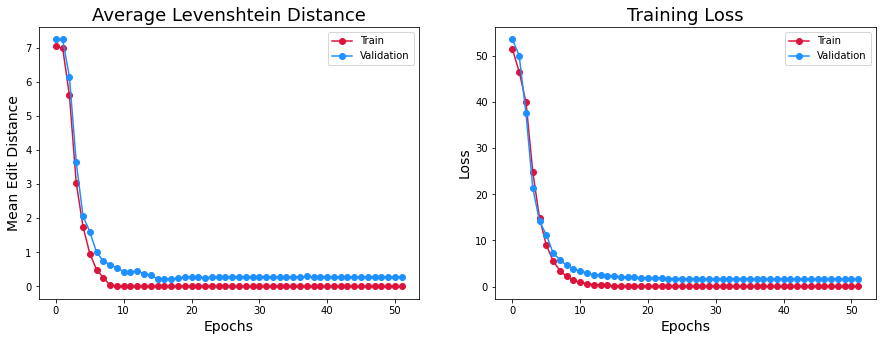

In [19]:
print(f'Fold {best_fold_idx + 1:02d} has the best result at epoch {best_fold_epoch + 1}:')
print(f'- Loss on validation: {best_loss}')
print(f'- Mean edit distance: {best_history["val_edist"][best_fold_epoch]}')
plot_training_results(best_history, f'{APPROACH_NAME}.png')
best_model.save(f'{APPROACH_NAME}.h5')

# Inference

In [20]:
from tensorflow.keras.models import Model, load_model
reloaded_model = load_model(f'{APPROACH_NAME}.h5', custom_objects={
    'CTCLoss': CTCLoss, 
    'MeanEditDistance': MeanEditDistance
})
reloaded_model.summary(line_length=100)

Model: "Model_02"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 image (InputLayer)              [(None, 148, 32, 1)]  0           []                               
                                                                                                    
 block1_conv1 (Conv2D)           (None, 148, 32, 64)   640         ['image[0][0]']                  
                                                                                                    
 block1_bn1 (BatchNormalization)  (None, 148, 32, 64)  256         ['block1_conv1[0][0]']           
                                                                                                    
 block1_activation1 (LeakyReLU)  (None, 148, 32, 64)   0           ['block1_bn1[0][0]']             
                                                                         

## On test dataset

Batch 01:
- True: {1: '歲𣃣𠄩糁芸專斈行', 2: '雲仙𠓨謝尊師𦋦𧗱', 3: '会尼\U000f0778及群除会芇', 4: '昆渚拮挭群\U000f0021𭛣之', 5: '小生庄別𬋟湄𠯿芇', 6: '尊師𦖑呐添傷', 7: '因机謀事𠴍浪', 8: '𡢐昆𠄩𡦂科期', 9: '朗名昆討匪願碎𬆄', 10: '為匕淡娄裊塘群賖', 11: '𥪝廊\U000f0778敢呐之', 12: '哙探屡奴群仃尼芇', 13: '芇埃併寔推欣爫之', 14: '䜹浪便妾𠫾塘', 15: '東城本寔圭茄', 16: '䜹浪\U000f0152﨤知音'}
- Pred: {1: '歲𣃣𠄩糁芸專斈行', 2: '雲仙𠓨謝香師𦋦𧗱', 3: '会尼\U000f0778及群除会芇', 4: '昆渚拮挭群句𭛣之', 5: '小生庄別𬋟湄𣅶芇', 6: '尊師𦖑呐添傷', 7: '因机謀事𠴍浪', 8: '𡢐昆𠄩𡦂科期', 9: '朗名昆討匪願碎𬆄', 10: '爲匕淡案裊塘群賖', 11: '𥪝跪\U000f0778敢呐之', 12: '哙探屡奴群仃尼芇', 13: '芇埃併寔推欣爫之', 14: '䜹浪便妾𠫾塘', 15: '東城本寔圭茄', 16: '䜹浪\U000f0152﨤知音'}

Batch 02:
- True: {1: '恩箕㐌買𧵑尼𢭂朗', 2: '埃𪟽𨅸\U000f061a𮎦雄', 3: '嘆浪簪咳\U000f047c簪', 4: '云仙和吏𠬠排𢭂𦋦', 5: '䀡詩買別𧵆賖', 6: '丿兜㐌細府堂', 7: '漏匕𠬠𬌓𢚸誠', 8: '𡀯娘𡢐唉群𥹰', 9: '云仙自\U000f060c月娥', 10: '情箕㐌﨤理芇爫𢗃', 11: '謝辞庙宇卞𨆢𦋦塘', 12: '曰书𠬠幅吲\U000f0803云仙', 13: '𡦂浪胡越一家', 14: '牢空結伴麻𠫾𠓨塲', 15: '\U000f0279枚𣃣𤎜蹎𡗶', 16: '\U000f0835戈水秀山岐'}
- Pred: {1: '恩箕㐌買𧵑尼𢭂朗', 2: '埃𪟽𨅸\U000f061a𮎦雄', 3: '嘆浪簪咹\U000f047c簪', 4: '云仙和吏𠬠排𢭂𦋦', 5: '䀡詩買別𧵆賖', 6: '丿兜㐌細府堂', 7: '漏匕𠬠𬌓𢚸誠', 8: '𡀯娘𡢐唉群𥹰', 9: '云仙自

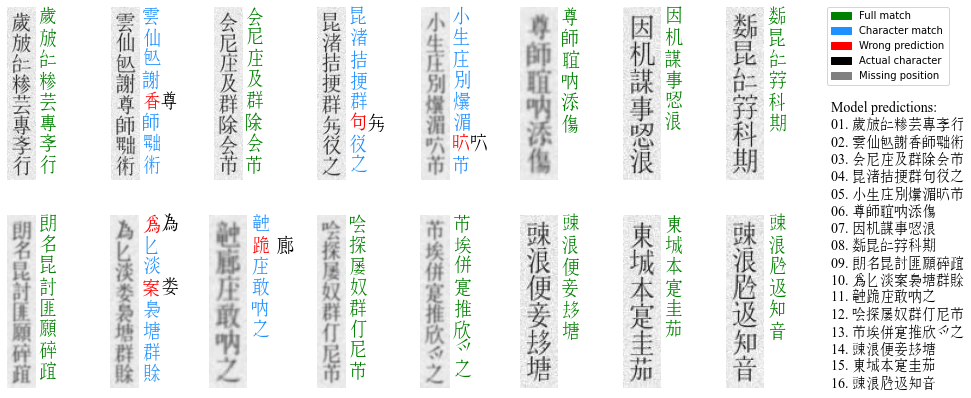

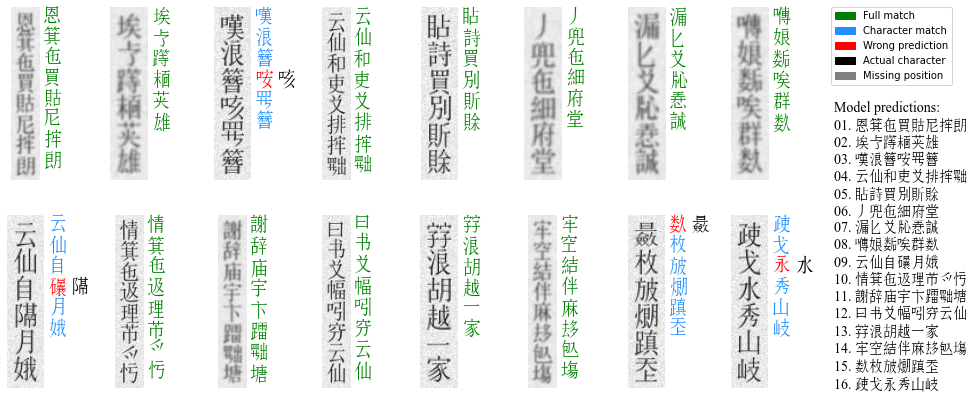

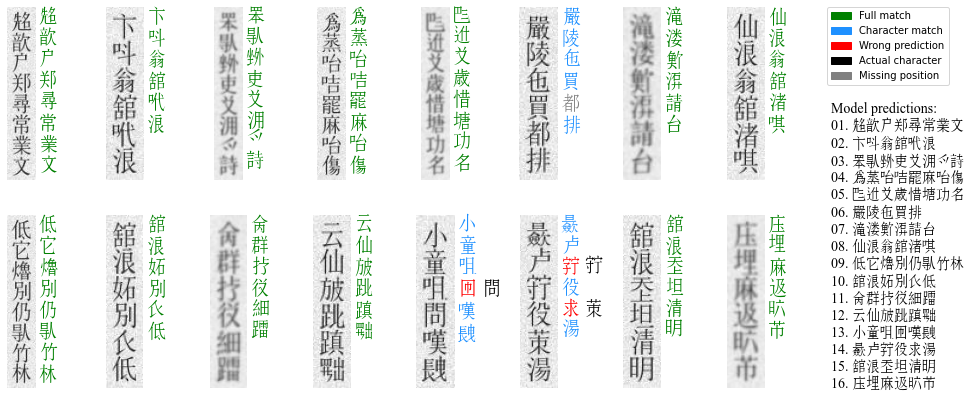

In [21]:
valid_dataset, valid_idxs = best_valid_dataset
for idx, (batch_images, batch_tokens) in enumerate(valid_dataset.take(3)):
    idxs_in_batch = valid_idxs[idx * BATCH_SIZE: (idx + 1) * BATCH_SIZE]
    pred_tokens = reloaded_model.predict(batch_images)
    
    labels = data_handler.tokens2texts(batch_tokens)
    pred_labels = data_handler.tokens2texts(pred_tokens, use_ctc_decode=True)
    
    visualize_images_labels(
        img_paths = img_paths[idxs_in_batch], 
        labels = labels, 
        pred_labels = pred_labels,
        font_path = FONT_PATH, 
        text_x = WIDTH + 3 
    )
    print(
        f'Batch {idx + 1:02d}:\n'
        f'- True: {dict(enumerate(labels, start=1))}\n'
        f'- Pred: {dict(enumerate(pred_labels, start=1))}\n'
    )

## On random image

In [22]:
random_path = '../大越史記全書.jpg'
random_label = '大越史記全書'
random_image = data_handler.process_image(random_path)
pred_tokens = reloaded_model.predict(tf.expand_dims(random_image, axis=0))
pred_labels = data_handler.tokens2texts(pred_tokens, use_ctc_decode=True)

Predicted text: 大越史記全書


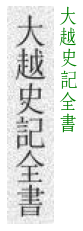

In [23]:
visualize_images_labels(
    img_paths = [random_path], 
    labels = [random_label], 
    pred_labels = pred_labels,
    figsize = (5, 4),
    subplot_size = (1, 1), 
    show_legend = False,
    font_path = FONT_PATH, 
    text_x = WIDTH + 3 # Position of actual label to plot
)
print('Predicted text:', ''.join(pred_labels))